Denis Aleksandrov, 5 January 2020

## Task

3. Session data
From our server logs, you can access the raw session data, that contains information about single visits to our website (= sessions). A click out is logged whenever a user clicks on a hotel and is redirected to the booking page. The booking field is binary and indicates if a hotel booking was logged after one of the click outs. Have a look at the data and check if there is any connection between the booking data and other given information. Feel free to formulate hypothesis based on your findings.

## Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
plt.style.use('seaborn-whitegrid')

import datetime
from scipy.stats import chi2_contingency
from scipy.stats import chi2

from pptx import Presentation
from pptx.util import Cm
from io import BytesIO

In [2]:
# initiate Presentation
prs = Presentation()
title_slide_layout = prs.slide_layouts[0]

slide = prs.slides.add_slide(title_slide_layout)
title = slide.shapes.title
title.text = "User Sessions Analysis"
subtitle = slide.placeholders[1]
subtitle.text = "by Denis Aleksandrov"

## Definitions

The following definitions are used in this analysis:
- *Session Duration*: time delta between Session Start and Session End
- *Min. Range (Minutes Range)*: batch for Session Duration. E.g. 0:53 duration will be in "0-1" range.

------

## Input data

- Server logs with raw session data about visits to website

------

## Data issues found
- There are 69 sessions with 0 Clickouts, but Booking logged.

    Probably they actually had Clickouts, but not logged. Will drop them in this analysis as they are only 0.69% of all sessions, but need to be investigated on server side.

------

## Results

Chi2-test shows the following connections results:
- Booking and Clickouts: independent.
- Booking and Session Duration: dependent.
- Booking and Session Start Hour: independent. Probably, sessions are generated by users from cities with different timezones, but the server's timestamps are in UTC.


Sessions Duration impact:
- The more time user spent on the website, the more likely he will book the hotel: group with session duration 1-2 minutes has only 6.23% of bookings, but 5-6 minutes has 14.94%.
- At the same time, group of 0-1 minutes has 7.77%. This probably means that there are some users who know exactly which hotel on which dates do they need, and visiting the website just to find the best price, not spending the time on reading hotels descriptions, comparisons etc.
- Group 6-7 min. has too little data to observe

------

## Get data & overview

In [3]:
# Load csv
df_sessions = pd.read_csv('session_data.csv', delimiter=';')

In [4]:
# Look on shape
df_sessions.shape

(10000, 5)

In [5]:
# Look on data
df_sessions.head()

,session,session_start_text,session_end_text,clickouts,booking
0,20170503000001,06:11:53,06:15:11,3,0
1,20170503000002,21:06:41,21:08:23,3,0
2,20170503000003,12:03:01,12:06:02,3,0
3,20170503000004,05:58:00,06:02:56,0,0
4,20170503000005,09:13:43,09:17:01,1,0


In [6]:
# Check for Null values
df_sessions.isnull().sum()

session               0
session_start_text    0
session_end_text      0
clickouts             0
booking               0
dtype: int64

In [7]:
# Check for duplicates
df_sessions.duplicated().sum()

0

In [8]:
# Look on datatypes
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
session               10000 non-null int64
session_start_text    10000 non-null object
session_end_text      10000 non-null object
clickouts             10000 non-null int64
booking               10000 non-null int64
dtypes: int64(3), object(2)
memory usage: 390.8+ KB


In [9]:
df_sessions.describe()

,session,clickouts,booking
count,1.000000e+04,10000.000000,10000.000000
mean,2.017050e+13,2.485200,0.096700
std,2.886896e+03,1.060987,0.295564
min,2.017050e+13,0.000000,0.000000
25%,2.017050e+13,2.000000,0.000000
50%,2.017050e+13,2.000000,0.000000
75%,2.017050e+13,3.000000,0.000000
max,2.017050e+13,8.000000,1.000000


In [10]:
# Look on start/end min/max
print('Session Start min -- max: ', df_sessions.session_start_text.min(), '--', df_sessions.session_start_text.max() )
print('Session End min -- max: ', df_sessions.session_end_text.min(), '--', df_sessions.session_end_text.max() )

# Look on Clickouts min/max
print('Clickouts min -- max: ', df_sessions.clickouts.min(), '--', df_sessions.clickouts.max() )

Session Start min -- max:  00:00:00 -- 23:59:56
Session End min -- max:  00:00:12 -- 23:59:58
Clickouts min -- max:  0 -- 8


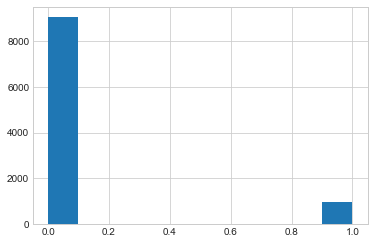

In [11]:
# Look on Booking distribution
df_sessions.booking.hist()

## Prepare data

In [12]:
# Convert session start/end to timestamps
df_sessions['session_start_ts'] = df_sessions.session_start_text.apply(lambda x: datetime.datetime.strptime(x, '%H:%M:%S'))
df_sessions['session_end_ts'] = df_sessions.session_end_text.apply(lambda x: datetime.datetime.strptime(x, '%H:%M:%S'))

# Add session Duration
df_sessions['session_duration_sec'] = (df_sessions.session_end_ts - df_sessions.session_start_ts).dt.total_seconds()

# Add session's Hour
df_sessions['session_start_hour'] = df_sessions['session_start_ts'].dt.strftime('%H').astype(int)

In [13]:
df_sessions.head()

,session,session_start_text,session_end_text,clickouts,booking,session_start_ts,session_end_ts,session_duration_sec,session_start_hour
0,20170503000001,06:11:53,06:15:11,3,0,1900-01-01 06:11:53,1900-01-01 06:15:11,198.0,6
1,20170503000002,21:06:41,21:08:23,3,0,1900-01-01 21:06:41,1900-01-01 21:08:23,102.0,21
2,20170503000003,12:03:01,12:06:02,3,0,1900-01-01 12:03:01,1900-01-01 12:06:02,181.0,12
3,20170503000004,05:58:00,06:02:56,0,0,1900-01-01 05:58:00,1900-01-01 06:02:56,296.0,5
4,20170503000005,09:13:43,09:17:01,1,0,1900-01-01 09:13:43,1900-01-01 09:17:01,198.0,9


In [14]:
# Look on sessions duration
df_sessions.session_duration_sec.describe()

count    10000.000000
mean        69.023500
std       3114.406156
min     -86301.000000
25%        139.000000
50%        182.000000
75%        223.000000
max        378.000000
Name: session_duration_sec, dtype: float64

In [15]:
df_sessions[df_sessions.session_duration_sec < 0].head()

,session,session_start_text,session_end_text,clickouts,booking,session_start_ts,session_end_ts,session_duration_sec,session_start_hour
725,20170503000726,23:59:00,00:01:23,0,0,1900-01-01 23:59:00,1900-01-01 00:01:23,-86257.0,23
742,20170503000743,23:57:00,00:02:24,2,0,1900-01-01 23:57:00,1900-01-01 00:02:24,-86076.0,23
1021,20170503001022,23:59:56,00:01:53,2,0,1900-01-01 23:59:56,1900-01-01 00:01:53,-86283.0,23
2041,20170503002042,23:56:43,00:00:12,4,0,1900-01-01 23:56:43,1900-01-01 00:00:12,-86191.0,23
2786,20170503002787,23:59:50,00:03:26,2,0,1900-01-01 23:59:50,1900-01-01 00:03:26,-86184.0,23


Some sessions started on one day before midnight and ended on next day. Let's recalculate their durations, by adding +1 day to End ts

In [16]:
df_sessions.loc[df_sessions.session_duration_sec < 0, 'session_duration_sec'] = (df_sessions.session_end_ts + datetime.timedelta(days=1) -  df_sessions.session_start_ts).dt.total_seconds()

In [17]:
df_sessions[df_sessions.session_duration_sec < 0].head()

,session,session_start_text,session_end_text,clickouts,booking,session_start_ts,session_end_ts,session_duration_sec,session_start_hour


In [18]:
df_sessions[df_sessions.session == 20170503000726].head()

,session,session_start_text,session_end_text,clickouts,booking,session_start_ts,session_end_ts,session_duration_sec,session_start_hour
725,20170503000726,23:59:00,00:01:23,0,0,1900-01-01 23:59:00,1900-01-01 00:01:23,143.0,23


Now looks correct

In [19]:
# Convert Duration to Minutes
df_sessions['session_duration_min'] = round(df_sessions.session_duration_sec / 60, 0).astype(int)

# Convert Duration to Minutes range (by 1 minute delta)
df_sessions['Session Duration Min. Range'] = (df_sessions.session_duration_sec / 60).astype(int)
df_sessions['Session Duration Min. Range'] = df_sessions['Session Duration Min. Range'].apply(lambda x: str(x)+'-'+str(x+1))

In [20]:
# Drop Start/End date, keep only time
df_sessions['session_start_ts'] = df_sessions.session_start_ts.apply(lambda x: x.time())
df_sessions['session_end_ts'] = df_sessions.session_end_ts.apply(lambda x: x.time())

In [21]:
df_sessions.head()

,session,session_start_text,session_end_text,clickouts,booking,session_start_ts,session_end_ts,session_duration_sec,session_start_hour,session_duration_min,Session Duration Min. Range
0,20170503000001,06:11:53,06:15:11,3,0,06:11:53,06:15:11,198.0,6,3,3-4
1,20170503000002,21:06:41,21:08:23,3,0,21:06:41,21:08:23,102.0,21,2,1-2
2,20170503000003,12:03:01,12:06:02,3,0,12:03:01,12:06:02,181.0,12,3,3-4
3,20170503000004,05:58:00,06:02:56,0,0,05:58:00,06:02:56,296.0,5,5,4-5
4,20170503000005,09:13:43,09:17:01,1,0,09:13:43,09:17:01,198.0,9,3,3-4


In [22]:
# Check for incorrect Clickouts data 
df_sessions[(df_sessions.clickouts == 0) & (df_sessions.booking == 1)].shape[0]

69

In [23]:
df_sessions[(df_sessions.clickouts == 0) & (df_sessions.booking == 1)].shape[0] / df_sessions.shape[0] * 100

0.69

There are 69 sessions with 0 Clickouts, but Booking logged.

Probably they actually had Clickouts, but not logged. Will drop them in this analysis as they are only 0.69% of all sessions, but need to be investigated on server side.

In [24]:
# Drop incorrect data
df_sessions = df_sessions[~((df_sessions.clickouts == 0) & (df_sessions.booking == 1))]

In [25]:
df_sessions.shape

(9931, 11)

## Analysis

### Chi2 Test

In [26]:
# Chi-squared test
def chi2_test(var1, var2):
    print('Chi2 test')
    print('H0: "Booking" is independent of "{}" \n'.format(var2.name))
    table = pd.crosstab(var1, var2)

    # print(table)
    stat, p, dof, expected = chi2_contingency(table)
    print('dof=%d' % dof)
    # print(expected)

    # interpret test-statistic
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
    if abs(stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')

    # interpret p-value
    alpha = 1.0 - prob
    print('significance=%.3f, p=%.3f \n' % (alpha, p))
    print('Result:')
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    print('|--------------------------| \n')

In [27]:
# Chi2 Test for Booking and a few variables
chi2_test(df_sessions.booking, df_sessions.session_start_hour)
chi2_test(df_sessions.booking, df_sessions.session_duration_min)
chi2_test(df_sessions[df_sessions.clickouts != 0].booking
          , df_sessions[df_sessions.clickouts != 0].clickouts)

Chi2 test
H0: "Booking" is independent of "session_start_hour" 

dof=23
probability=0.950, critical=35.172, stat=27.133
Independent (fail to reject H0)
significance=0.050, p=0.250 

Result:
Independent (fail to reject H0)
|--------------------------| 

Chi2 test
H0: "Booking" is independent of "session_duration_min" 

dof=6
probability=0.950, critical=12.592, stat=35.315
Dependent (reject H0)
significance=0.050, p=0.000 

Result:
Dependent (reject H0)
|--------------------------| 

Chi2 test
H0: "Booking" is independent of "clickouts" 

dof=6
probability=0.950, critical=12.592, stat=5.464
Independent (fail to reject H0)
significance=0.050, p=0.486 

Result:
Independent (fail to reject H0)
|--------------------------| 



Chi2-test shows the following connections results:
- Booking and Clickouts: independent.
- Booking and Session Duration: dependent.
- Booking and Session Start Hour: independent. Probably, sessions are generated by users from cities with different timezones, but the server's timestamps are in UTC.

### Distributions

In [28]:
# Calculate Sessions distribution by groups
def calc_sessions_distribution(var):
    df_bookings_by_group = pd.DataFrame(df_sessions.groupby([var, 'booking']).size())
    df_bookings_by_group = df_bookings_by_group.reset_index().pivot(index=var, columns='booking', values=0)

    df_bookings_by_group['Total Sessions'] = df_bookings_by_group[0] + df_bookings_by_group[1]
    df_bookings_by_group['% Booked'] = df_bookings_by_group[1] / df_bookings_by_group['Total Sessions']
    df_bookings_by_group['% Booked'] = round(df_bookings_by_group['% Booked'], 4)
    df_bookings_by_group.fillna(0, inplace=True)
    
    return df_bookings_by_group

In [29]:
# Plot Sessions distribution and % of Booked by group
def plot_distribution(df, title, ax_label, xlabel, leg_loc):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,1,1)

    ax.set_title(title, fontsize=20)
    ax.bar(df.index, df['Total Sessions'], label=ax_label)
#     ax.set_xticks(df.Week.values)
    ax.set_xlabel(xlabel, fontsize=13)
#     ax.set_ylabel('Euro', fontsize=13)

    ax2 = ax.twinx() 
    ax2.plot(df.index, df['% Booked'], label='% Booked', color='green')
    ax2.set_ylabel('% Booked', fontsize=13)
    ax2.yaxis.set_major_formatter(PercentFormatter(1))
    
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc=leg_loc, fontsize=12, frameon=True)

    # create buffer for image
    plot_image = BytesIO()
    plt.savefig(plot_image)

    # save plot to pptx
    slide = prs.slides.add_slide(title_slide_layout)
    title = slide.shapes.title
    subtitle = slide.placeholders[1]
    left = Cm(0)
    top = Cm(3)
    width = Cm(25)
    pic = slide.shapes.add_picture(plot_image, left, top, width)

    plt.show()

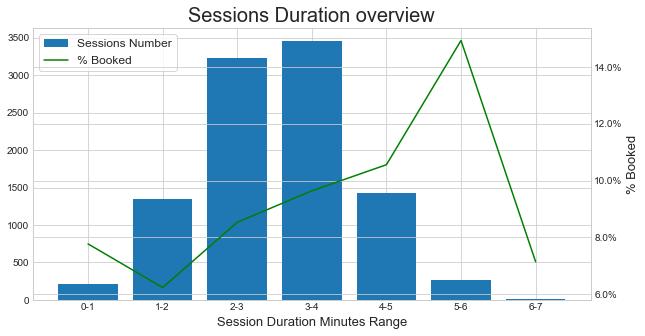

booking,0,1,Total Sessions,% Booked
Session Duration Min. Range,,,,
0-1,190,16,206,7.77%
1-2,1265,84,1349,6.23%
2-3,2949,275,3224,8.53%
3-4,3123,333,3456,9.64%
4-5,1271,150,1421,10.56%
5-6,222,39,261,14.94%
6-7,13,1,14,7.14%


In [30]:
df_duration_groups = calc_sessions_distribution('Session Duration Min. Range')
plot_distribution(df=df_duration_groups
                 ,title='Sessions Duration overview'
                 ,ax_label='Sessions Number'
                 ,xlabel='Session Duration Minutes Range'
                 ,leg_loc='upper left')
display(df_duration_groups.style.format({'% Booked': '{:,.2%}'.format}))

- The more time user spent on the website, the more likely he will book the hotel: group with session duration 1-2 minutes has only 6.23% of bookings, but 5-6 minutes has 14.94%.
- At the same time, group of 0-1 minutes has 7.77%. This probably means that there are some users who know exactly which hotel on which dates do they need, and visiting the website just to find the best price, not spending the time on reading hotels descriptions, comparisons etc.
- Group 6-7 min. has too little data to observe

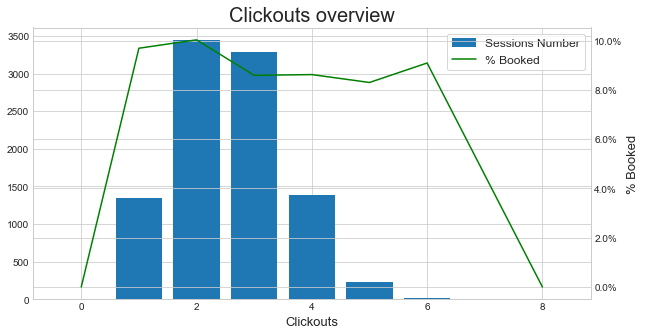

booking,0,1,Total Sessions,% Booked
clickouts,,,,
0,224,0,0,0.00%
1,1221,131,1352,9.69%
2,3096,345,3441,10.03%
3,3010,283,3293,8.59%
4,1261,119,1380,8.62%
5,210,19,229,8.30%
6,10,1,11,9.09%
8,1,0,0,0.00%


In [31]:
df_clickouts_groups = calc_sessions_distribution('clickouts')
plot_distribution(df=df_clickouts_groups
                 ,title='Clickouts overview'
                 ,ax_label='Sessions Number'
                 ,xlabel='Clickouts'
                 ,leg_loc='upper right')
display(df_clickouts_groups.style.format({'% Booked': '{:,.2%}'.format}))

Clickouts do not show significant impact on bookings (the same as we found with Chi2 Test)

# Appendix

In [32]:
# Save slides to presentation
prs.save('Presentation_Sessions_raw.pptx')